In [30]:
import sys
sys.path.append('../')

In [31]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms, utils
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import io
import json

In [32]:
# Cargamos el modelo vgg16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [33]:
def cnn(image):
    image_copy = image.copy()
    # Convertimos la imagen a escala de grises y la redimensionamos para que la acepte VGG16.
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    image_copy = cv2.resize(image_copy,(224,224), interpolation=cv2.INTER_AREA)
    # Preprocesamos  la imagen.
    image_copy = preprocess_input(image_copy)
    image_batch = np.expand_dims(image_copy, axis=0)
    original_stdout = sys.stdout
    sys.stdout = io.StringIO()
    features = vgg.predict(image_batch)
    features = features.reshape(features.shape[0],(512*7*7))

    return features

In [34]:
from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

In [35]:
test_meta, test_images = load_images(False)
train_meta, train_images = load_images(True)

In [36]:
def calcular_dist_chi2(images_path,query_desc,best_k):
    def chi2_distance(a, b, epsilon=1e-10):
        return 0.5 * np.sum(((a - b) ** 2) / (a + b + epsilon))
    with open(images_path,'r') as f:
        index = json.load(f)
    
    results = {}
    # Compara el descriptor de la imagen de consulta con todos los que tenemos en el índice, almacenando
    # la distancia entre cada par de vectores
    for file_name, descriptor in index.items():
        distance = chi2_distance(descriptor, query_desc)
        results[file_name] = distance
    
    results = sorted([(value, key) for key, value in results.items()])
    return results[:best_k]

In [37]:
query_idx = 47
query_img = test_images[query_idx]
query_desc = cnn(query_img)
query_desc.shape[1]

25088

In [38]:
# SOLO EJECUTAR LA PRIMERA VEZ
# descriptores,meta_desc = extract_features(cnn,train_images)
# save_features(descriptores,meta_desc,train_meta,"descriptores_CNN")

In [44]:
meta_desc, descriptores = load_features('../features/descriptores_CNN.csv')

In [45]:
matches_L1 = minmin_retrival(query_desc,descriptores,meta_desc,best_k=5,distance_function=cv2.NORM_L1)

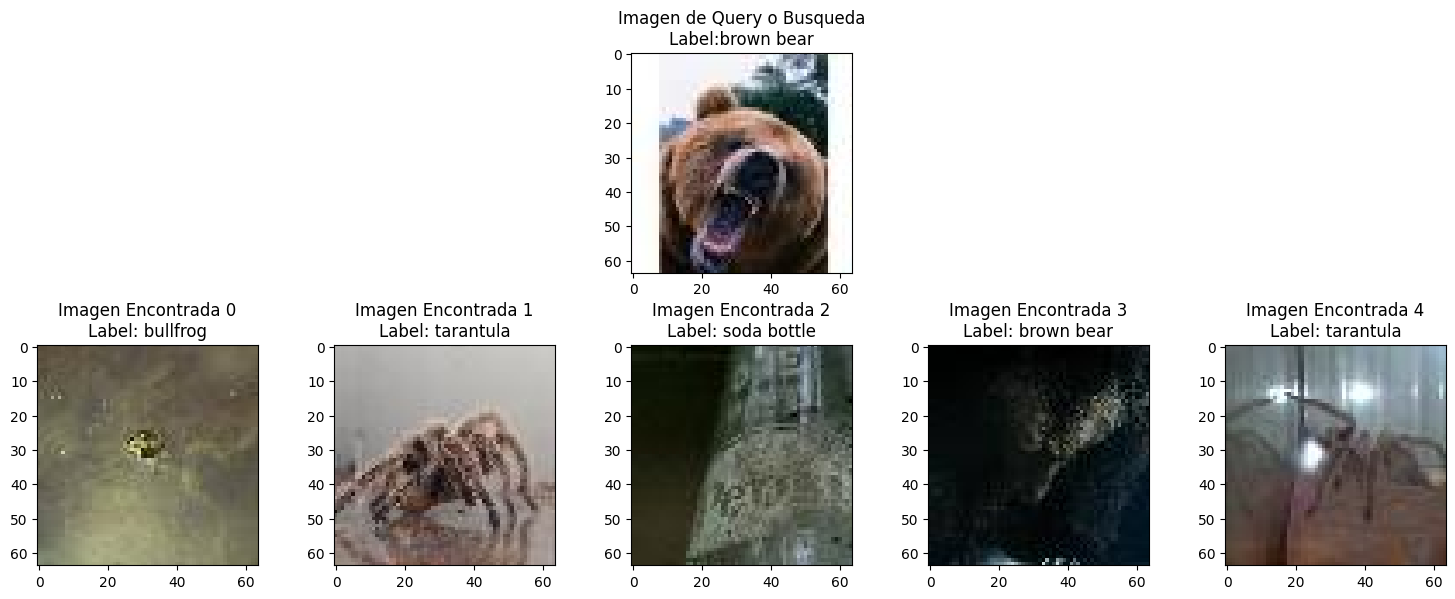

In [46]:
fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(test_images[query_idx])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[query_idx, 'label'])
for i, img_id in enumerate(matches_L1[:5], start = 0):
    ax[1][i].imshow(train_images[img_id])
    label = train_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}")

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()

In [42]:
matches_L2 = minmin_retrival(query_desc,descriptores,meta_desc,best_k=5,distance_function=cv2.NORM_L2)

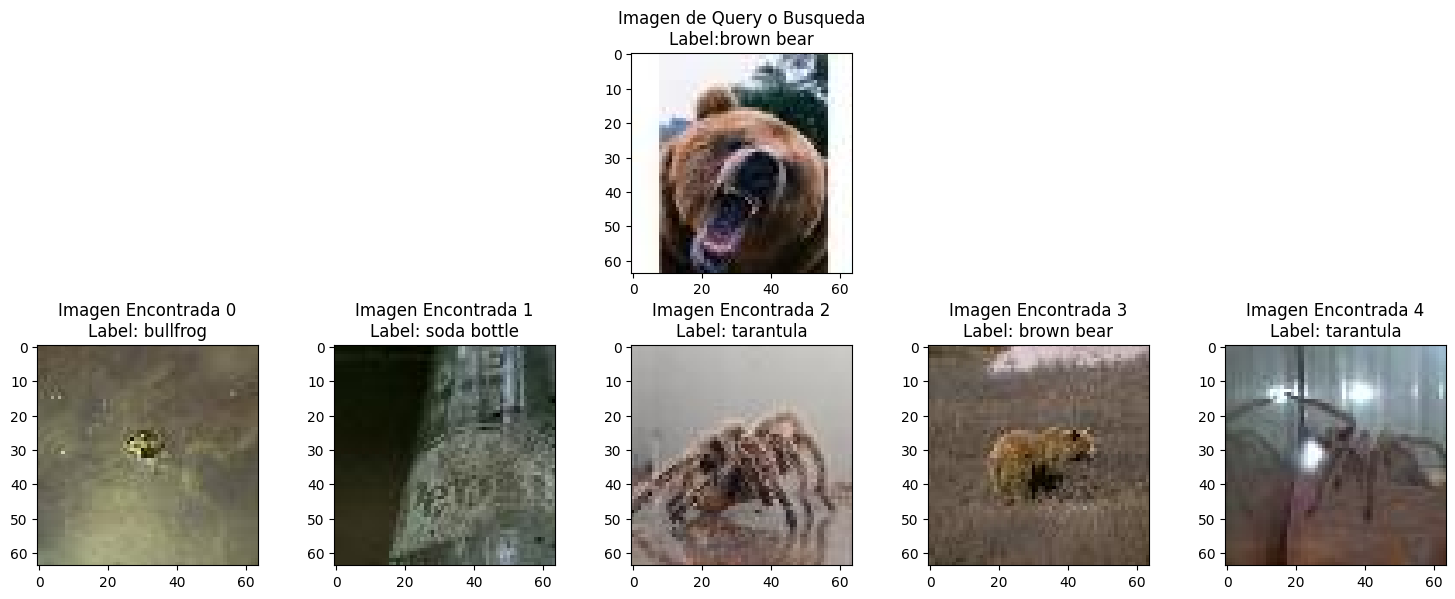

In [43]:
fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(test_images[query_idx])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[query_idx, 'label'])
for i, img_id in enumerate(matches_L2[:5], start = 0):
    ax[1][i].imshow(train_images[img_id])
    label = train_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}")

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()